# price analysis by neighborhood

In [206]:
import pandas as pd
import glob

search_string = 'data/apts_all_?bedrooms.pkl'

data = pd.concat([
    pd.concat([d.reset_index(drop=True), pd.Series([bdr,]*len(d), name='bedrooms')], axis=1) for d,bdr in [
        (pd.read_pickle(p),int(p.split('apts_all_')[1][0])) for p in glob.glob(search_string)
    ]
]).set_index('code')
data['date'] = pd.DatetimeIndex(data.date)
data['day'] = data.date.apply(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))

In [157]:
axs[i].get_xticks()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

Index(['inner richmond', 'laurel hts / presidio', 'lower haight',
       'alamo square / nopa', 'inner sunset / UCSF', 'richmond / seacliff',
       'haight ashbury', 'cole valley / ashbury hts', 'castro / upper market',
       'lower pac hts'],
      dtype='object', name='location')

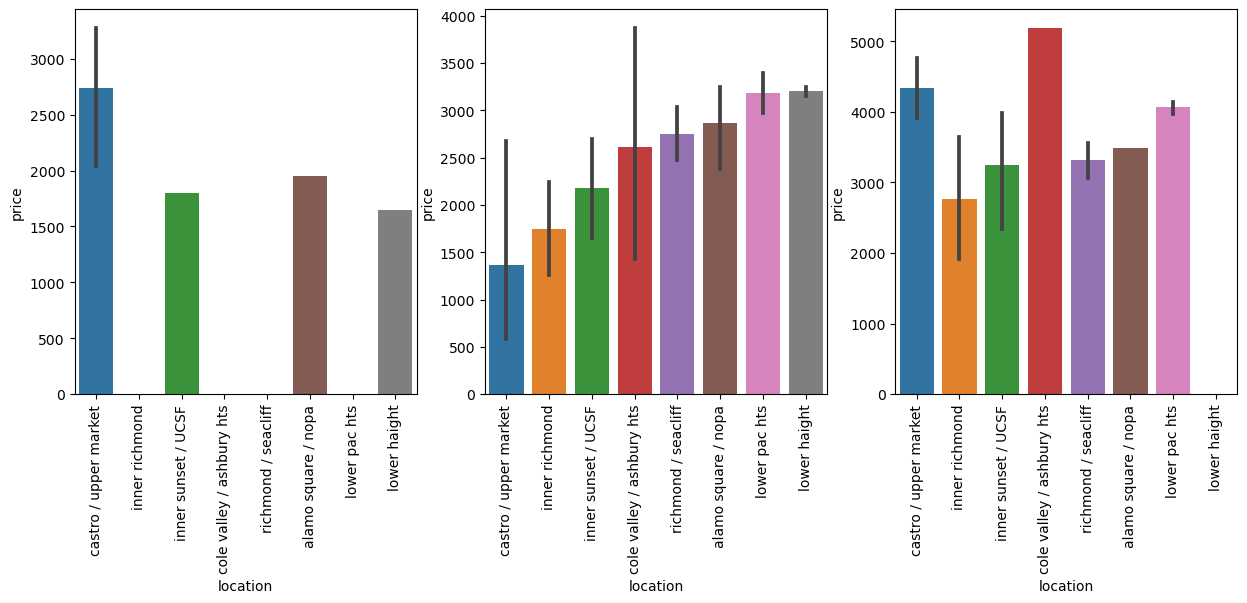

In [165]:
import seaborn as sns

ordering = list(data[data.bedrooms ==1].groupby('location').price.mean().sort_values().index)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i,n in enumerate(data.bedrooms.unique()):
    sns.barplot(data=data[data.bedrooms == n], y='price', x='location', ax=axs[i], order=ordering)
    axs[i].set_xticks(axs[i].get_xticks(), axs[i].get_xticklabels(), rotation=90)

In [136]:
data.groupby(['location', 'bedrooms', pd.Grouper(freq='D', key='date', label='left')]).price.mean()

location                   bedrooms  date      
alamo square / nopa        0         2023-05-26         1950.0
                           1         2023-05-24         1550.0
                                     2023-05-25         3265.0
                                     2023-05-26    2913.333333
                           2         2023-05-25         3495.0
castro / upper market      0         2023-05-24         2312.0
                                     2023-05-25         2889.5
                                     2023-05-26         3279.0
                           1         2023-05-24         3300.0
                                     2023-05-25     716.666667
                           2         2023-05-24         4000.0
                                     2023-05-25        4336.75
                                     2023-05-26         4442.0
cole valley / ashbury hts  1         2023-05-25         2617.0
                           2         2023-05-25         5195.0
haight 

In [171]:
weekly = data.groupby(['bedrooms', 'location', pd.Grouper(key='date', freq='D', label='left')])
mu, sigma = weekly.price.mean(), weekly.price.std()

In [177]:
mu.index.get_level_values('bedrooms').unique()

Index([0, 1, 2], dtype='int64', name='bedrooms')

In [180]:
mu[1,'alamo square / nopa']

date
2023-05-24         1550.0
2023-05-25         3265.0
2023-05-26    2913.333333
Freq: D, Name: price, dtype: object

In [ ]:
mu[0, ]

In [189]:
mu

date                               2023-05-24   2023-05-25   2023-05-26
bedrooms location                                                      
0        alamo square / nopa              NaN          NaN       1950.0
         castro / upper market         2312.0       2889.5       3279.0
         haight ashbury                   NaN          NaN       1750.0
         inner sunset / UCSF              NaN       1800.0          NaN
         lower haight                     NaN       1650.0          NaN
1        alamo square / nopa           1550.0       3265.0  2913.333333
         castro / upper market         3300.0   716.666667          NaN
         cole valley / ashbury hts        NaN       2617.0          NaN
         inner richmond                2895.0       1438.0       2100.0
         inner sunset / UCSF              NaN       2175.0          NaN
         lower haight                     NaN       3250.0       3150.0
         lower pac hts                 3162.5       3162.5       3250.0
         richmond / seacliff           3295.0          NaN      2611.25
2        alamo square / nopa              NaN       3495.0          NaN
         castro / upper market         4000.0      4336.75       4442.0
         cole valley / ashbury hts        NaN       5195.0          NaN
         haight ashbury                   NaN          NaN       4500.0
         inner richmond                   NaN       3017.0       1500.0
         inner sunset / UCSF           3835.0       3490.0       2765.0
         laurel hts / presidio            NaN          NaN       2500.0
         lower pac hts                    NaN  4058.333333       4125.0
         richmond / seacliff           3430.0       3330.0       2995.0

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

weekly = data.groupby(['bedrooms', 'location', pd.Grouper(key='date', freq='D', label='left')])
total = data.groupby(['bedrooms', pd.Grouper(key='date', freq='D', label='left')])

mu, sigma = weekly.price.mean(), weekly.price.std()
mut, sigmat = total.price.mean(), total.price.std()
# plt.fill_between(
#     x[filt], (mu.values-sigma.values)[filt], (mu.values + sigma.values)[filt],
#     alpha=.3,
# )
# plt.plot(mu.index, mu.values)
nbeds = mu.index.get_level_values('bedrooms').nunique()
fig, axs = plt.subplots(1, nbeds, figsize=(5*nbeds, 5), sharey=True)

for j,n in enumerate(mu.index.get_level_values('bedrooms').unique()):
    ax = axs[j]
    for i,loc in enumerate(sorted(mu.index.get_level_values('location').unique())):
        try:
            ax.errorbar(
                mu[n, loc].index + datetime.timedelta(hours=i), mu[n, loc].values, yerr=sigma[n, loc].values,
                marker='x', capsize=5, markersize=10, ls='none',
        #         color='tab:blue'
            )

        except Exception as e:
            pass
            
        sel = (data.location == loc) & (data.bedrooms == n)
        ax.scatter(data[sel].date, data[sel].price, label=loc)

    ax.errorbar(
        mut[n].index - datetime.timedelta(hours=1), mut[n].values, 
        yerr=sigmat[n].values, marker='o', capsize=5, markersize=5,
        color='black', label='combined'
    )
    ax.set_xticks(sorted(mu.index.get_level_values('date').unique()), 
                  sorted(mu.index.get_level_values('date').unique()),
#                   mu.columns.strftime('%h %d %H00'), 
                  rotation=90
            )
    ax.set_title('{}-bedrooms'.format(n))
axs[-1].legend(loc=(1.05,0.5))
#     ax.legend()
# plt.scatter()
plt.show()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


In [200]:
total.price.mean()

bedrooms  date      
0         2023-05-24         2312.0
          2023-05-25        2307.25
          2023-05-26    2326.333333
1         2023-05-24    2894.166667
          2023-05-25         2176.4
          2023-05-26         2768.5
2         2023-05-24         3660.0
          2023-05-25    3709.833333
          2023-05-26    3385.545455
Name: price, dtype: object

Index(['1600 May 24', '1700 May 24', '1800 May 24', '1900 May 24',
       '2000 May 24', '2100 May 24', '2200 May 24', '2300 May 24',
       '0000 May 25', '0100 May 25', '0200 May 25', '0300 May 25',
       '0400 May 25', '0500 May 25', '0600 May 25', '0700 May 25',
       '0800 May 25', '0900 May 25', '1000 May 25', '1100 May 25',
       '1200 May 25', '1300 May 25', '1400 May 25', '1500 May 25',
       '1600 May 25', '1700 May 25', '1800 May 25', '1900 May 25'],
      dtype='object', name='date')

name   
0   Cole Valley Studio • Open floor plan • Large c...  \
1   May Sublet - 1 bd in 2 bed apartment (weekly a...   
2   Large Victorian Styled Room Available in Centr...   
3   1BR 1BATH NEAR UCSF PARNASSUS BRAND NEW KITCHE...   
4   Fully furnished room with private bathroom and...   
5   GORGEOUS ONE-BEDROOM in the Heart of Cole Vall...   
6            Updated 1 Bedroom Apt in Corona Heights!   
7       large 1 bedroom in classic Edwardian building   
8    1 BR./1 BA. - APARTMENT - VIEWING BY APPOINTMENT   
9   Huge 1BR Apt w/ Laundry On-site & Parking Incl...   
10               Cute, 1 bdrm, walk in closet, quiet!   
11                                  4 Rooms Near UCSF   
12  4931 17th St. - Lovely 1bd/1ba with Serene Bac...   
13  Top Fl,1BR in Cole Valley, Shrader between Riv...   
14  Bright corner 1 bedroom/1 bath washer/dryer wi...   
15                   Fully Remodeled One Bedroom Plus   
16                              Remodeled One bedroom   
17                              Cozy One Bedroom Plus   
18            Cozy, quiet One Bedroom Fully Remodeled   
19                     Cozy, Fully redone one Bedroom   
20                        A Must See Cute One Bedroom   
21  Gorgeous Ashbury Heights 1-Bedroom With Brand ...   
22  Cole valley classic Victorian 1bd,1ba fully fu...   
23  Fantiastic Flat with Formal dining room, Gas f...   
24  Fantiastic Flat with Formal dining room, Gas f...   
25  Gorgeous Ashbury Heights 1-Bedroom With Dining...   
26                          Wonderful 1 Br. near UCSF   
27  Spacious Cole valley classic Victorian fully f...   
28  1 BR - Super Cute Sunny Fully Renovated w/Form...   
29  Sunny Super Cute Renovated One Bedroom w/Forma...   
30  Super Cute Renovated One Bedroom w/Formal Dini...   
31                      2 bdr. with awesome City view   
32       SCAM ALERT, mid-century condo in Cole valley   
33     Large two bedroom with floor to ceiling window   
34  Extraordinary 2 bdrm, 2 bath apt. with City view.   
35                SPACIUOS COLE VALLEY EDWARDIAN FLAT   
36                SPACIOUS COLE VALLEY EDWARDIAN FLAT   
37                SPACIOUS COLE VALLEY EDWARDIAN FLAT   
38  Large Classic Two Bedroom + Formal dining room...   

                                                 link   
0   https://sfbay.craigslist.org/sfc/apa/d/san-fra...  \
1   https://sfbay.craigslist.org/sfc/sub/d/san-fra...   
2   https://sfbay.craigslist.org/sfc/roo/d/san-fra...   
3   https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
4   https://sfbay.craigslist.org/sfc/sub/d/san-fra...   
5   https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
6   https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
7   https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
8   https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
9   https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
10  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
11  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
12  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
13  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
14  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
15  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
16  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
17  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
18  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
19  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
20  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
21  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
22  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
23  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
24  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
25  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
26  https://sfbay.craigslist.org/sfc/sub/d/san-fra...   
27  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
28  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
29  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
3

In [119]:
data.groupby(pd.Grouper(key='date', freq='W-MON', label='left')).price

In [85]:
data.groupby(pd.DatetimeIndex(data.date))

In [71]:
pd.read_pickle('data/apts_bdr1_cole.pkl')

name   
0   Cole Valley Studio • Open floor plan • Large c...  \
1   May Sublet - 1 bd in 2 bed apartment (weekly a...   
2   Large Victorian Styled Room Available in Centr...   
3   1BR 1BATH NEAR UCSF PARNASSUS BRAND NEW KITCHE...   
4   Fully furnished room with private bathroom and...   
5   GORGEOUS ONE-BEDROOM in the Heart of Cole Vall...   
6            Updated 1 Bedroom Apt in Corona Heights!   
7       large 1 bedroom in classic Edwardian building   
8    1 BR./1 BA. - APARTMENT - VIEWING BY APPOINTMENT   
9   Huge 1BR Apt w/ Laundry On-site & Parking Incl...   
10               Cute, 1 bdrm, walk in closet, quiet!   
11                                  4 Rooms Near UCSF   
12  Top Fl,1BR in Cole Valley, Shrader between Riv...   
13  4931 17th St. - Lovely 1bd/1ba with Serene Bac...   
14  Bright corner 1 bedroom/1 bath washer/dryer wi...   
15                   Fully Remodeled One Bedroom Plus   
16                              Remodeled One bedroom   
17                              Cozy One Bedroom Plus   
18            Cozy, quiet One Bedroom Fully Remodeled   
19                     Cozy, Fully redone one Bedroom   
20                        A Must See Cute One Bedroom   
21  Gorgeous Ashbury Heights 1-Bedroom With Brand ...   
22  Cole valley classic Victorian 1bd,1ba fully fu...   
23  Fantiastic Flat with Formal dining room, Gas f...   
24  Fantiastic Flat with Formal dining room, Gas f...   
25  Gorgeous Ashbury Heights 1-Bedroom With Dining...   
26                          Wonderful 1 Br. near UCSF   
27  Spacious Cole valley classic Victorian fully f...   
28  1 BR - Super Cute Sunny Fully Renovated w/Form...   
29  Sunny Super Cute Renovated One Bedroom w/Forma...   
30  Super Cute Renovated One Bedroom w/Formal Dini...   
31                      2 bdr. with awesome City view   
32       SCAM ALERT, mid-century condo in Cole valley   
33     Large two bedroom with floor to ceiling window   
34  Extraordinary 2 bdrm, 2 bath apt. with City view.   
35                SPACIOUS COLE VALLEY EDWARDIAN FLAT   
36                SPACIUOS COLE VALLEY EDWARDIAN FLAT   
37                SPACIOUS COLE VALLEY EDWARDIAN FLAT   
38  Large Classic Two Bedroom + Formal dining room...   

                                                 link   
0   https://sfbay.craigslist.org/sfc/apa/d/san-fra...  \
1   https://sfbay.craigslist.org/sfc/sub/d/san-fra...   
2   https://sfbay.craigslist.org/sfc/roo/d/san-fra...   
3   https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
4   https://sfbay.craigslist.org/sfc/sub/d/san-fra...   
5   https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
6   https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
7   https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
8   https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
9   https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
10  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
11  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
12  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
13  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
14  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
15  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
16  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
17  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
18  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
19  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
20  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
21  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
22  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
23  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
24  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
25  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
26  https://sfbay.craigslist.org/sfc/sub/d/san-fra...   
27  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
28  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
29  https://sfbay.craigslist.org/sfc/apa/d/san-fra...   
3